In [7]:
import asyncio
import websockets
import json
import pandas as pd
import nest_asyncio
import matplotlib.pyplot as plt
nest_asyncio.apply()
import warnings
import numpy as np
import datetime
warnings.filterwarnings("ignore")

# Первый метод

In [15]:
# To subscribe to this channel:
msg = \
    {"jsonrpc": "2.0",
     "method": "public/subscribe",
     "id": 42,
     "params": {
        "channels": ["markprice.options.btc_usd"]}
    }
# собираем ответы 
# просто код примера с сайте deribit-а
responses = []
async def call_api(msg):
    async with websockets.connect('wss://test.deribit.com/ws/api/v2') as websocket:
        await websocket.send(msg)
        while websocket.open:
            response = await websocket.recv()
            responses.append(response)
            
asyncio.get_event_loop().run_until_complete(call_api(json.dumps(msg)))

In [ ]:
parsed = []
columns = ["timestamp", "mark_price", "iv", "instrument_name"]
data = pd.DataFrame(columns=columns)
for response in responses:
    resp_json = json.loads(response)
    try:
        singles = resp_json["params"]["data"]
    except:
        continue
    for single in singles:
        data = data.append(pd.DataFrame([[single["timestamp"], single["mark_price"], single["iv"], single["instrument_name"]]], columns=columns))
    

In [3]:
data["human_timestamp"] = data["timestamp"].apply(lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f'))


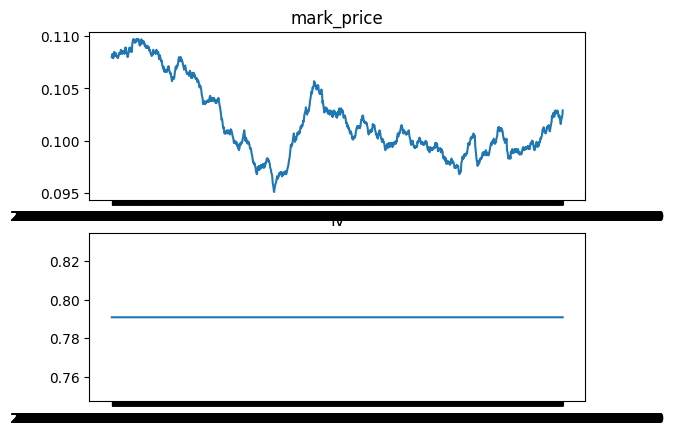

In [6]:
sample = data[data["instrument_name"] == data.instrument_name.sample(1).iloc[0]]
fig, (ax0, ax1) = plt.subplots(2, 1)
ax0.plot(sample["human_timestamp"], sample["mark_price"])
ax0.set_title("mark_price")
ax1.plot(sample["human_timestamp"], sample["iv"])
ax1.set_title("iv")
plt.show()


In [7]:
sample.sort_values(by = "timestamp").drop_duplicates().tail(10)

,timestamp,mark_price,iv,instrument_name,human_timestamp
0,1664392831477,0.1020,0.7908,BTC-29SEP22-21500-P,2022-09-28 22:20:31.477000
0,1664392834491,0.1018,0.7908,BTC-29SEP22-21500-P,2022-09-28 22:20:34.491000
0,1664392836499,0.1016,0.7908,BTC-29SEP22-21500-P,2022-09-28 22:20:36.499000
0,1664392845535,0.1017,0.7908,BTC-29SEP22-21500-P,2022-09-28 22:20:45.535000
0,1664392846539,0.1020,0.7908,BTC-29SEP22-21500-P,2022-09-28 22:20:46.539000
0,1664392847543,0.1021,0.7908,BTC-29SEP22-21500-P,2022-09-28 22:20:47.543000
0,1664392848546,0.1022,0.7908,BTC-29SEP22-21500-P,2022-09-28 22:20:48.546000
0,1664392850554,0.1023,0.7908,BTC-29SEP22-21500-P,2022-09-28 22:20:50.554000
0,1664392853566,0.1025,0.7908,BTC-29SEP22-21500-P,2022-09-28 22:20:53.566000
0,1664392855575,0.1029,0.7908,BTC-29SEP22-21500-P,2022-09-28 22:20:55.575000


In [ ]:
data.to_pickle("options.pkl")

# Второй метод

## Соберем все id-щники и опционы, которым они соответсвуют

In [8]:
msg = \
{
  "jsonrpc" : "2.0",
  # "id" : 7617,
  "method" : "public/get_instruments",
  "params" : {
    "currency" : "BTC",
    "kind" : "option",
    "expired" : False
  }
}

async def call_api(msg):
    async with websockets.connect('wss://test.deribit.com/ws/api/v2') as websocket:
        await websocket.send(msg)
        while websocket.open:
            response = await websocket.recv()
            return json.loads(response)


instruments = asyncio.get_event_loop().run_until_complete(call_api(json.dumps(msg)))
instruments_df = []
for instrument in instruments["result"]:
    instruments_df.append([instrument["instrument_name"], instrument["instrument_id"]])
instruments_df = pd.DataFrame(instruments_df, columns = ["instrument_name", "instrument_id"])


In [9]:
instruments_df

,instrument_name,instrument_id
0,BTC-20OCT22-16000-C,139861
1,BTC-20OCT22-16000-P,139862
2,BTC-20OCT22-17000-C,139863
3,BTC-20OCT22-17000-P,139864
4,BTC-20OCT22-17500-C,139865
...,...,...
283,BTC-29SEP23-30000-P,138449
284,BTC-29SEP23-40000-C,138450
285,BTC-29SEP23-40000-P,138451
286,BTC-29SEP23-50000-C,138452


## Собираем данные по конкретному опциону

In [15]:
msg = \
    {"jsonrpc": "2.0",
     "method": "public/get_order_book_by_instrument_id",
     # ранломный id опциона из датафрейма выше
     "id": 139863,
     "params": {
        "instrument_id": 139863,
        "depth": 5.0}
    }
async def call_api(msg):
    prices = []
    counter = 0
    max_counter = 20000
    async with websockets.connect('wss://test.deribit.com/ws/api/v2') as websocket:
        while websocket.open:
            if counter>=max_counter:
                break
            await websocket.send(msg)
            response = await websocket.recv()
            # print(response)
            prices.append(json.loads(response))
            counter+=1
            continue
    return prices
            
prices = asyncio.get_event_loop().run_until_complete(call_api(json.dumps(msg)))

In [16]:
df = []
columns = ["instrument_name", "timestamp", "mark_iv", "mark_price", "best_bid_price", "best_ask_price"]
for result in prices:
    df.append([result["result"]["instrument_name"], 
          result["result"]["timestamp"],
          result["result"]["mark_iv"], 
          result["result"]["mark_price"],
          result["result"]["best_bid_price"],
          result["result"]["best_ask_price"]]) 
df = pd.DataFrame(df, columns = columns)
df["human_timestamp"] = df["timestamp"].apply(lambda x : datetime.datetime.fromtimestamp(x/1000.0).strftime('%Y-%m-%d %H:%M:%S.%f'))
df = df.drop_duplicates()


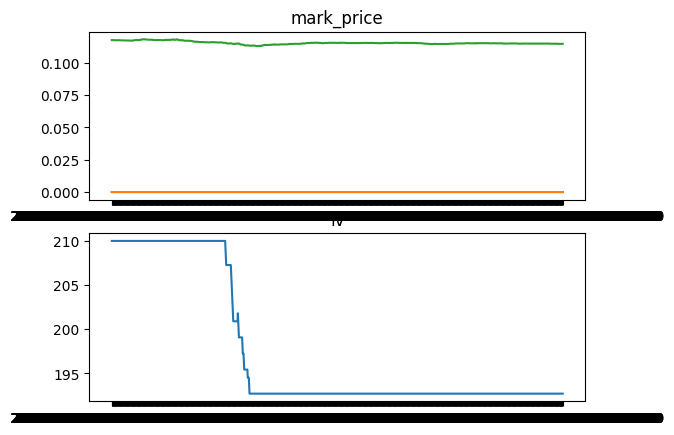

In [17]:
fig, (ax0, ax1) = plt.subplots(2, 1)
ax0.plot(df["human_timestamp"], df["best_ask_price"])
ax0.plot(df["human_timestamp"], df["best_bid_price"])
ax0.plot(df["human_timestamp"], df["mark_price"])

ax0.set_title("mark_price")
ax1.plot(df["human_timestamp"], df["mark_iv"])
ax1.set_title("iv")
plt.show()


In [19]:
df

,instrument_name,timestamp,mark_iv,mark_price,best_bid_price,best_ask_price,human_timestamp
0,BTC-20OCT22-17000-C,1666209731068,209.99,0.1177,0.0,0.0,2022-10-19 23:02:11.068000
6,BTC-20OCT22-17000-C,1666209732076,209.99,0.1177,0.0,0.0,2022-10-19 23:02:12.076000
37,BTC-20OCT22-17000-C,1666209734086,209.99,0.1177,0.0,0.0,2022-10-19 23:02:14.086000
52,BTC-20OCT22-17000-C,1666209735095,209.99,0.1177,0.0,0.0,2022-10-19 23:02:15.095000
63,BTC-20OCT22-17000-C,1666209736101,209.99,0.1177,0.0,0.0,2022-10-19 23:02:16.101000
...,...,...,...,...,...,...,...
19919,BTC-20OCT22-17000-C,1666211063350,192.72,0.1148,0.0,0.0,2022-10-19 23:24:23.350000
19934,BTC-20OCT22-17000-C,1666211064357,192.72,0.1148,0.0,0.0,2022-10-19 23:24:24.357000
19950,BTC-20OCT22-17000-C,1666211065364,192.72,0.1148,0.0,0.0,2022-10-19 23:24:25.364000
19965,BTC-20OCT22-17000-C,1666211066367,192.72,0.1148,0.0,0.0,2022-10-19 23:24:26.367000


In [18]:
df.to_pickle("data/BTC-20OCT22-17000-C.pkl")